  
 # How do you feel now?

#### NLP project to Emotion Classification through your text

<!-- ![image](https://github.com/zeyadusf/What-are-you-feeling-now/assets/83798621/5e9962d5-d2c4-4562-9202-e0b74969d840) -->




## 🎯 About : ##
"How are you feeling now?" That's the name of this project, and it's about Emotion  classification: developing models to accurately classify tweets into six defined sentiment categories. Illusion (sadness, joy, love, anger, fear, or surprise).

* 🔗 This data from Kaggel was used to train the model:[Emotions](https://www.kaggle.com/datasets/nelgiriyewithana/emotions)
* I used a Tokenizer from torch and the architecture of the model consists of (Bi-LSTM, Conc1D) , You can view the code through this links on:
    - 🔗 Kaggel : [How do you feel now?](https://www.kaggle.com/code/zeyadusf/how-do-you-feel-now?)
    - 🔗 **GitHub**:  [How do you feel now?](https://github.com/zeyadusf/How-do-you-feel-now)


  <hr>
  
<!--Social Media-->

### 📧 Contact ##

<p>
<a href="https://www.linkedin.com/in/zeyadusf/" target="_blank">
  <img src="https://img.shields.io/badge/-Zeyad Usf-0077B5?style=flat&logo=linkedin&logoColor=white" alt="LinkedIn" />
</a>

<a href="https://github.com/zeyadusf" target="_blank">
  <img src="https://img.shields.io/badge/-@zeyadusf-181717?style=flat&logo=github&logoColor=white" alt="GitHub" />
</a>

<a href="https://www.instagram.com/zeyadusf/" target="_blank">
  <img src="https://img.shields.io/badge/-zeyadusf-white?style=flat&logo=instagram&logoColor=#E65468" alt="Instagram" />
</a>

</p>




# import libraries

In [1]:
!pip install torchtext

In [2]:
import pandas as pd
import numpy as np
import random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# 
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader , Dataset
import torch.nn as nn
import torch.nn.functional as F


# 
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score
# 
import warnings
warnings.filterwarnings('ignore')

2024-07-06 12:52:55.813508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 12:52:55.813612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 12:52:55.961210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<hr>

# Helper

In [3]:
class Var :
    MAX_LEN = 128
    BATCH_SIZE= 128
    EPOCHS=5
    VOCAB=0
    PATH_DATA= r'/kaggle/input/emotions/text.csv'
    PATH_OUTPUT=r'/kaggle/working/'
var=Var()

In [4]:
class EmotionsDatasets(Dataset):
    def __init__(self, texts, labels, tokenizer, vocab, max_length):
        self.texts = texts  
        self.labels = labels
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_length = max_length
        self.padding_value = vocab['<pad>']
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if idx < len(self.labels):
            text = self.texts[idx]
            label = self.labels[idx]

            # Tokenize text
            tokenized_text = self.tokenizer(text)
            
            # Convert tokens to indices using vocab
            indexed_tokens = [self.vocab[token] for token in tokenized_text if token in self.vocab]
            
            # Pad or truncate sequence to max_length
            if len(indexed_tokens) < self.max_length:
                indexed_tokens += [self.padding_value] * (self.max_length - len(indexed_tokens))
            else:
                indexed_tokens = indexed_tokens[:self.max_length]

            # Convert to tensor
            encoding = torch.LongTensor(indexed_tokens)

            return {
                'input_ids': encoding,
                'labels': torch.tensor(label, dtype=torch.float),
            }
        else:
            raise IndexError("Index out of range")


In [5]:
# initializ tokenizer
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

In [6]:
def pie_dis_label(data):
    """  pie - distribute data """
    label_counts = data['label'].value_counts()
    plt.figure(figsize=(5, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Labels')
    plt.axis('equal')  
    plt.show()
    
def hist_text_len(data):
    """histogram - text length distribution"""
    plt.figure(figsize=(10, 6))
    sns.histplot(data, x='len', bins=30, kde=True, color='blue')
    plt.title('Text Length Distribution')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.show()

<hr>

# Read Data & EDA

In [7]:
df= pd.read_csv(var.PATH_DATA,encoding='utf-8',sep=',')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.sample(10)

,text,label
256789,i feel it s my duty to warn you about somethin...,5
99226,i feel slightly dissatisfied shield my eyes fr...,3
355897,i feel so elegant while teaching art to crazy ...,1
210711,i feel a little stunned but can t imagine what...,5
324482,i set out to make a copycat version of it satu...,1
82674,i feel its important to understand what youre ...,1
19157,i feel shocked at how fast and unexpectedly we...,5
391560,i have not learnt to hide feelings or stay coo...,1
181164,i always feel inspired and very happy after ou...,1
295506,ive been in a situation where i was not necess...,1


In [8]:
df.describe(include='object').T

,count,unique,top,freq
text,416809,393822,i feel more adventurous willing to take risks,16


In [9]:
df.drop_duplicates(subset=['text'], inplace=True)

## Distribution of Labels | All data

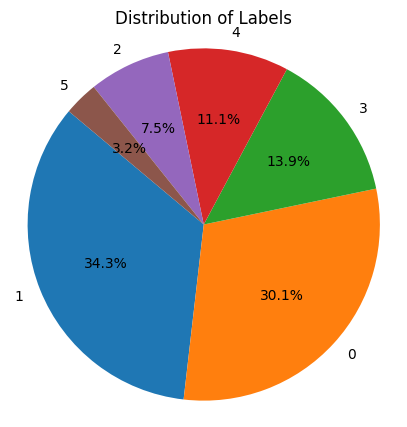

In [10]:
pie_dis_label(df)

## Histogram - text length distribution

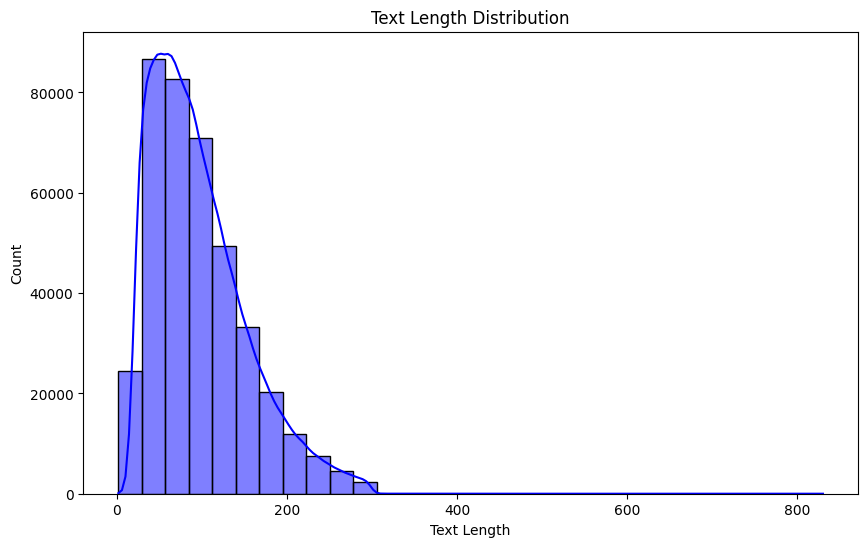

In [11]:
df['len']=df['text'].apply(lambda x:len(x))
hist_text_len(df)

In [12]:
fig = px.box(df, x="len",title='Box Plot')
fig.show()

In [13]:
df[df['len'] > 128]['label'].value_counts()

label
1    34470
0    27041
3    13416
4    10926
2     8526
5     3248
Name: count, dtype: int64

## split data 

In [14]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
test_df, val_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'])
train_df.drop(['len'],axis=1,inplace=True)
val_df.drop(['len'],axis=1,inplace=True)
test_df.drop(['len'],axis=1,inplace=True)

In [15]:
train_df.shape, test_df.shape ,val_df.shape

((315057, 2), (39382, 2), (39383, 2))

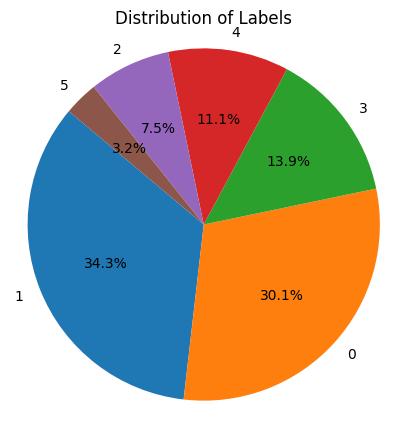

In [16]:
pie_dis_label(train_df)

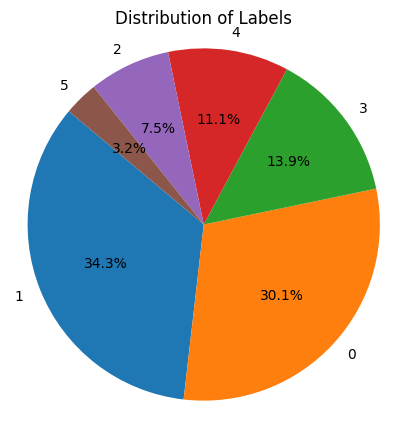

In [17]:
pie_dis_label(val_df)

# Preprocess Dataset

In [18]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(df['text'].to_list()), specials=["<sos>" ,"<unk>","<pad>","<eos>"])
vocab.set_default_index(vocab["<unk>"])

In [19]:
var.VOCAB=len(vocab)
var.VOCAB

75306

In [20]:

train_lables_Multi  = to_categorical(train_df['label']) 
val_lables_Multi  = to_categorical(val_df['label'])

(train_lables_Multi.shape ) , (val_lables_Multi.shape )

((315057, 6), (39383, 6))

In [21]:

train_dataset = EmotionsDatasets(train_df['text'].to_list(),train_lables_Multi.tolist(), tokenizer, vocab, max_length=var.MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=var.BATCH_SIZE)

val_dataset = EmotionsDatasets(val_df['text'].to_list(),val_lables_Multi.tolist(), tokenizer, vocab, max_length=var.MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size=var.BATCH_SIZE)


# Create Model

In [22]:
import torch.nn.functional as F

class EmotionsModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, max_length):
        super(EmotionsModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)  # Use bidirectional LSTM
        self.conv1d = nn.Conv1d(in_channels=2 * hidden_dim, out_channels=128, kernel_size=3, padding=1)  # Adjust in_channels for bidirectional
        self.bn_conv = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        # Process lstm_out with conv1d and batch normalization
        conv_out = F.relu(self.conv1d(lstm_out.transpose(1, 2)))
        conv_out = self.bn_conv(conv_out.transpose(1, 2)).transpose(1, 2)
        
        # Max pooling over time
        pooled = F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)
        
        # Apply dropout and fully connected layer
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        
        return logits

# Example usage:
model = EmotionsModel(vocab_size=var.VOCAB, embedding_dim=128, hidden_dim=128, num_classes=6, max_length=128)
model


EmotionsModel(
  (embedding): Embedding(75306, 128)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (conv1d): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_conv): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

# Training Process

In [23]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = var.EPOCHS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



EmotionsModel(
  (embedding): Embedding(75306, 128)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (conv1d): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_conv): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [24]:
import matplotlib.pyplot as plt


# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0
    total_train_samples = 0
    
    for  batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, labels = batch['input_ids'], batch['labels'] 
        inputs, labels = inputs.to(device), labels.to(device)  
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        true_labels = torch.argmax(labels, dim=1)
        _, predicted = torch.max(outputs, 1)        
        batch_accuracy = accuracy_score(true_labels.cpu().numpy(), predicted.cpu().numpy())
        
        epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_accuracy += batch_accuracy * inputs.size(0)
        total_train_samples += inputs.size(0)
    
    epoch_train_loss /= total_train_samples
    epoch_train_accuracy /= total_train_samples
    
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {epoch_train_accuracy:.4f}")
    
    # Validation loop
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    total_val_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['input_ids'], batch['labels']  
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            true_labels = torch.argmax(labels, dim=1)
            _, predicted = torch.max(outputs, 1)
            batch_accuracy = accuracy_score(true_labels.cpu().numpy(), predicted.cpu().numpy())
            
            epoch_val_loss += loss.item() * inputs.size(0)
            epoch_val_accuracy += batch_accuracy * inputs.size(0)
            total_val_samples += inputs.size(0)
    
    epoch_val_loss /= total_val_samples
    epoch_val_accuracy /= total_val_samples
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {epoch_val_accuracy:.4f}")




100%|██████████| 2462/2462 [01:19<00:00, 31.09it/s]


Epoch [1/5], Train Loss: 0.2744, Train Accuracy: 0.8953
Epoch [1/5], Val Loss: 0.0789, Val Accuracy: 0.9603


100%|██████████| 2462/2462 [01:17<00:00, 31.65it/s]


Epoch [2/5], Train Loss: 0.0766, Train Accuracy: 0.9622
Epoch [2/5], Val Loss: 0.0681, Val Accuracy: 0.9627


100%|██████████| 2462/2462 [01:17<00:00, 31.96it/s]


Epoch [3/5], Train Loss: 0.0641, Train Accuracy: 0.9652
Epoch [3/5], Val Loss: 0.0628, Val Accuracy: 0.9634


100%|██████████| 2462/2462 [01:17<00:00, 31.59it/s]


Epoch [4/5], Train Loss: 0.0580, Train Accuracy: 0.9673
Epoch [4/5], Val Loss: 0.0611, Val Accuracy: 0.9641


100%|██████████| 2462/2462 [01:16<00:00, 32.00it/s]


Epoch [5/5], Train Loss: 0.0542, Train Accuracy: 0.9691
Epoch [5/5], Val Loss: 0.0605, Val Accuracy: 0.9641


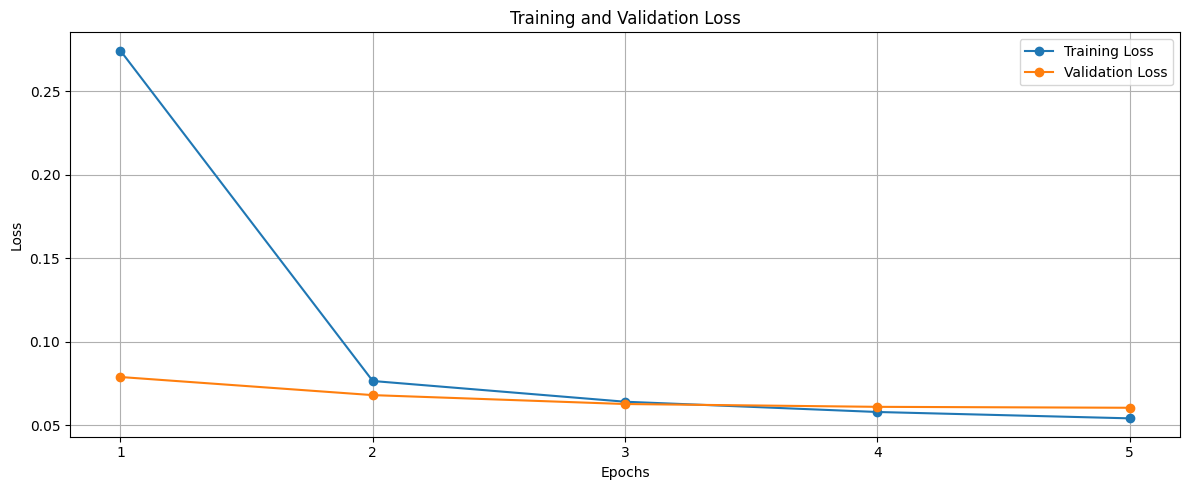

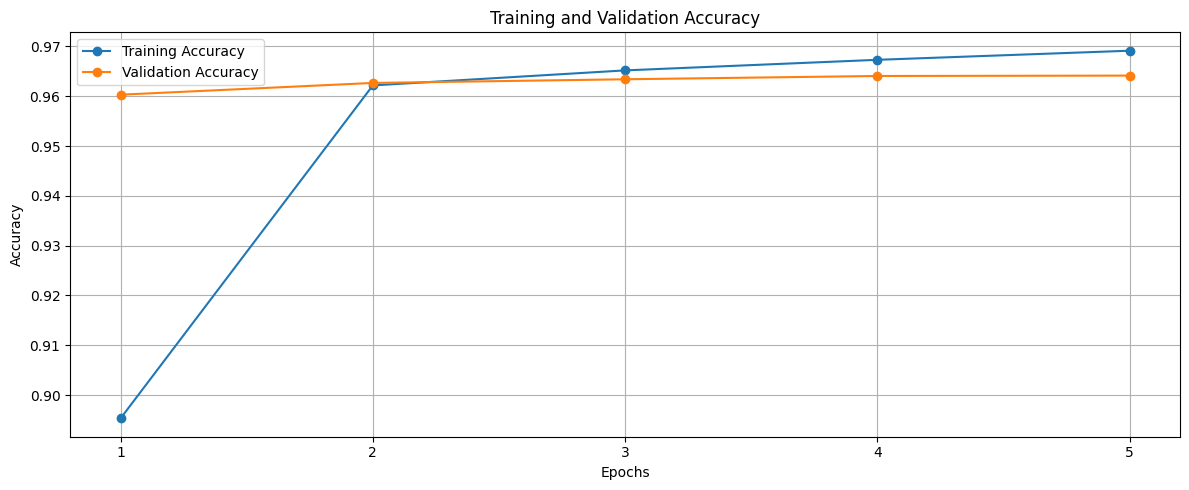

In [25]:
# Plotting train and validation losses
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, '-o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# Plotting train and validation accuracies
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, '-o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

## Test

In [26]:
test_lables_Multi  = to_categorical(test_df['label'])

test_dataset = EmotionsDatasets(test_df['text'].to_list(),test_lables_Multi.tolist(), tokenizer, vocab, max_length=var.MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=var.BATCH_SIZE)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()  # Set the model to evaluation mode
test_labels = []
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs, labels = batch['input_ids'], batch['labels']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Convert labels to class indices
        true_labels = torch.argmax(labels, dim=1)
        
        # Convert outputs to predicted class indices
        _, predicted = torch.max(outputs, 1)
        
        # Collect true labels and prediction4s
        test_labels.extend(true_labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
test_labels = np.array(test_labels)
predictions = np.array(predictions)


100%|██████████| 308/308 [00:05<00:00, 55.57it/s]


# Evaluation

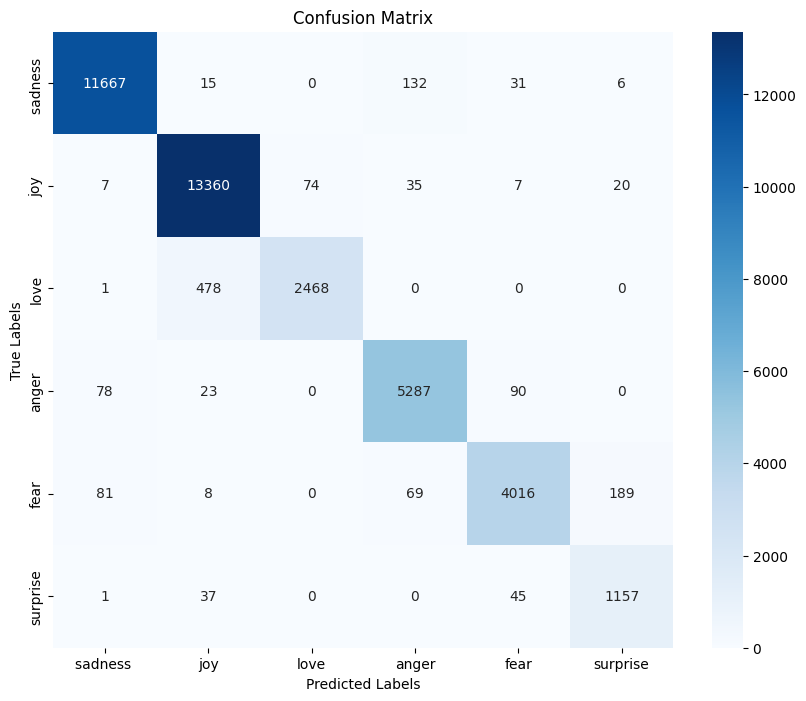

In [28]:
# Calculate confusion matrix
label_names= ['sadness ','joy' , 'love' ,'anger' ,'fear' , 'surprise' ]
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [29]:
# Generate classification report
report = classification_report(test_labels, predictions, target_names=label_names)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    sadness        0.99      0.98      0.99     11851
         joy       0.96      0.99      0.97     13503
        love       0.97      0.84      0.90      2947
       anger       0.96      0.97      0.96      5478
        fear       0.96      0.92      0.94      4363
    surprise       0.84      0.93      0.89      1240

    accuracy                           0.96     39382
   macro avg       0.95      0.94      0.94     39382
weighted avg       0.96      0.96      0.96     39382



<hr>

In [30]:
# save
model_scripted = torch.jit.script(model) 
model_scripted.save('model_emotions.pt') 

# Inference

In [31]:
model_path='/kaggle/working/model_emotions.pt'
model_emotions = torch.jit.load(model_path)
model_emotions.eval()  


RecursiveScriptModule(
  original_name=EmotionsModel
  (embedding): RecursiveScriptModule(original_name=Embedding)
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (conv1d): RecursiveScriptModule(original_name=Conv1d)
  (bn_conv): RecursiveScriptModule(original_name=BatchNorm1d)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc): RecursiveScriptModule(original_name=Linear)
)

In [32]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import torch.nn.functional as F

def tokenize_text(tokenizer, text, vocab, max_length):
    # Tokenize input text
    tokenized_text = tokenizer(text)

    # Convert tokens to indices using vocab
    indexed_tokens = [vocab[token] for token in tokenized_text if token in vocab]

    # Pad or truncate sequence to max_length
    if len(indexed_tokens) < max_length:
        indexed_tokens += [vocab['<pad>']] * (max_length - len(indexed_tokens))
    else:
        indexed_tokens = indexed_tokens[:max_length]

    # Convert to tensor
    input_tensor = torch.LongTensor(indexed_tokens).unsqueeze(0)  # Add batch dimension

    return input_tensor

In [33]:
index_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


def inference(model, tokenizer, vocab, max_length, text, device):
    # Tokenize and encode input text
    input_tensor = tokenize_text(tokenizer, text, vocab, max_length).to(device)

    # Set model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(input_tensor)

    # Apply softmax to get probabilities
    probabilities = F.softmax(outputs, dim=1)

    # Get predicted label (assuming it's a classification task)
    _, predicted = torch.max(probabilities, 1)

    return predicted.item(), probabilities.squeeze().tolist()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [34]:
txt='i am sad'
max_length=128


predicted_label, probabilities = inference(model_emotions, tokenizer, vocab, max_length, txt, device)

print(f"Predicted Label: {index_to_emotion[predicted_label]}")
print(f"Probabilities: {probabilities}")


Predicted Label: sadness
Probabilities: [0.6907023787498474, 0.03291019797325134, 0.0025683967396616936, 0.05761723965406418, 0.21329154074192047, 0.002910319482907653]
